### Dog vs Cat Classification

In [1]:
# Dataset - https://www.kaggle.com/datasets/salander/dogs-vs-cats

## Kaggle dataset

In [2]:
'''
Next set up your Kaggle API credentials in a Jupyter Notebook or a terminal.
'''
!mkdir -p ~/.kaggle
'''
This command creates a hidden directory called .kaggle in your home folder (~).
The -p flag ensures that the directory is created only if it doesn’t already exist.
'''
!cp kaggle.json ~/.kaggle/
'''
This command copies the kaggle.json file (which contains your API credentials) to the .kaggle folder.
'''

cp: cannot stat 'kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
100% 1.06G/1.06G [00:51<00:00, 24.0MB/s]
100% 1.06G/1.06G [00:51<00:00, 22.1MB/s]


In [4]:
# When we download our dataset, its in the form of a zip file. So, extracting zip file
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content') # after extraction 2 folders, train and test will be created.
# inside train and test folder we have cats and dogs folder containing cats and dogs image.
'''
This directory structure is very important. If 1st folder in train is of cats then in test also it should be of cats.
because model tries to understand that images belonging to cat folder are of cat class and those belonging to
dog folder are of dog class.
'''
zip_ref.close()

In [5]:
# importing libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout

In [6]:
#Training data and validation data from directory
# keras.utils has a method image_dataset_from_directory() which helps in reading images from directory
# so 1st we need to path location of directory. Next inferred means automatically detect the label.
# so 1st label is cats and 2nd label is dogs based on folder's name cats and dogs..
# so inferred does what, it makes the folder's name as labels.
# now this label is a text , but to a model we can't send text, so label_mode=int says label to be
# of integer type. So cats will have 0 integer and dogs will have 1 integer. So whichever folder is 1st , will get index 0.
# next is batch-size, this tells in each batch how many images u want to keep.Here 32.This can be anything like 16,8,64,24,32
# If the batch size is very big like 100 or something , then training will be fast but training quality won't be good.
# Next , in this folder, the images are of arbritrary size. So, making all the images of same input size becuase
# CNN wants all the images of same size. This is also the preprocessing part required in CNN. This is like model's input_size.
# cv2.resize() can make all the images of same size. But in Keras library this is done simply by image_size=(256,256).
# next is seed. Seed is the random state. This is just like of train_test_split.
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256),
    seed=12
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256),
    seed=12
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [49]:
train_ds # simply printing train_ds doesn't output anything becuase it is a keras library object.
# so to see the images inside it, iterate using for loop

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [7]:
len(train_ds)

625

In [50]:
# Checking training data i.e images inside train_ds
# we putted break because, i dont want to run for complete batches,
# instead only for the 1st batch.
for i in train_ds:
  x = i
  break

In [51]:
# so x contains 32 images of size height=256 width=256 with 3 channels
# scroll down and u will see 1 more numpy array which conatins labels for each image.
x

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
 array([[[[0.33816445, 0.4188017 , 0.21806641],
          [0.26284084, 0.3530369 , 0.14911535],
          [0.3460248 , 0.45092678, 0.24332874],
          ...,
          [0.5197811 , 0.600945  , 0.40854302],
          [0.4882506 , 0.5835947 , 0.38710746],
          [0.4133521 , 0.51755416, 0.31811428]],
 
         [[0.45460802, 0.5352453 , 0.33451   ],
          [0.29707798, 0.38727406, 0.18335249],
          [0.26245692, 0.36735886, 0.15976083],
          ...,
          [0.41687444, 0.5036391 , 0.31684378],
          [0.5070408 , 0.60507905, 0.41411802],
          [0.4606809 , 0.56376   , 0.37216988]],
 
         [[0.44675532, 0.5292222 , 0.327877  ],
          [0.3779412 , 0.47034314, 0.26642156],
          [0.30719593, 0.412343  , 0.20474495],
          ...,
          [0.42506415, 0.519672  , 0.3314367 ],
          [0.45030925, 0.55227005, 0.36403474],
          [0.52027136, 0.6234519 , 0.4346067 ]],
 
         ...,
 
      

In [52]:
print(x[0].shape)
print(x[1].shape)

(32, 256, 256, 3)
(32,)


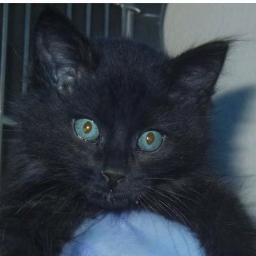

In [10]:
from google.colab.patches import cv2_imshow
cv2_imshow(x[0][0].numpy()) # x[0] is batch 0, x[0][0] is 0th image of batch 0.

In [11]:
for i in train_ds:
  x = i[0][0]
  y = i[-1][0]
  break

In [12]:
print(y)

tf.Tensor(0, shape=(), dtype=int32)


In [13]:
# Normalize by using tensorflow cast function. and convert values into tf.float32 datatype.
# we have tf.float64 too but that consumes more memory in storing images.
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label
# applying process() on triaining and testing data to normalize.
train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

## Base model

In [14]:
# creating a very simple base model first
# create CNN model

model = Sequential()

# same takes more time than valid.This input shape should be same as defined earlier, with number of channels.
model.add(Conv2D(32,kernel_size=(3,3),padding='same',activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

model.add(Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

model.add(Conv2D(128,kernel_size=(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid')) # output node has only 1 node becuase its a binary classification problem

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      16,777,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,878,913 (64.39 MB)

 Trainable params: 16,878,913 (64.39 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Accuracy'])

In [17]:
history = model.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 77ms/step - Accuracy: 0.6238 - loss: 0.6728 - val_Accuracy: 0.7220 - val_loss: 0.5481
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - Accuracy: 0.7611 - loss: 0.4887 - val_Accuracy: 0.7798 - val_loss: 0.4504
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 78s 71ms/step - Accuracy: 0.8416 - loss: 0.3579 - val_Accuracy: 0.7832 - val_loss: 0.5010
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 73ms/step - Accuracy: 0.9075 - loss: 0.2243 - val_Accuracy: 0.7966 - val_loss: 0.6386
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 72ms/step - Accuracy: 0.9580 - loss: 0.1086 - val_Accuracy: 0.7964 - val_loss: 0.7748
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 86s 79ms/step - Accuracy: 0.9780 - loss: 0.0663 - val_Accuracy: 0.7942 - val_loss: 0.9017
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 80ms/step - Accuracy: 0.9825 - loss: 0.0598 - val_Accuracy: 0.7878 - val_loss: 1.0564
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - Accuracy: 0.9873 - loss: 0.0387 - 

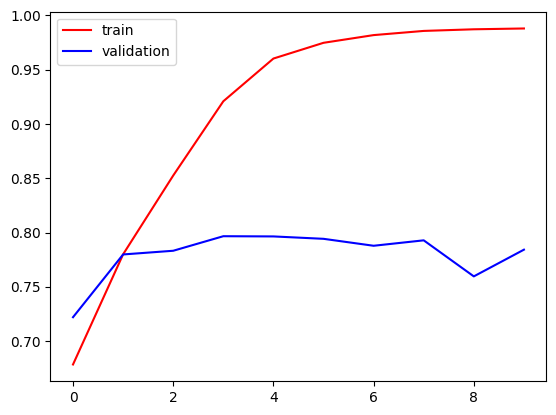

In [18]:
'''
by plotting training accuracy and val_accuracy and training loss and validation loss
we can chek for overfitting . So, accuracy should be high and loss should be low.
'''
import matplotlib.pyplot as plt

plt.plot(history.history['Accuracy'],color='red',label='train')
plt.plot(history.history['val_Accuracy'],color='blue',label='validation')
plt.legend()
plt.show()
# now there is too much gap between training and validation accuracy.
# Accuracy: 0.9880 while val_Accuracy: 0.7842

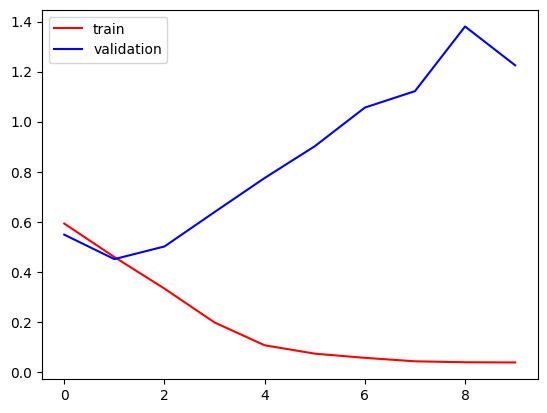

In [19]:
# lly training loss is very less where as testing loss is increasing.
# the more the gap in between them, the more is overfitting.
# our goal is they should be closer.
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [20]:
# ways to reduce overfitting

# Add more data
# Data Augmentation -> next video
# Dropout
# Batch Norm
# Reduce complexity i.e. number of layers in model. Right now our model is not very complicated.

In [21]:
# So,creating another CNN model by adding batchnormalization on cnn ,
# dropout we can only apply on ANN and not on CNN..

model1 = Sequential()

model1.add(Conv2D(32,kernel_size=(3,3),padding='same',activation='relu',input_shape=(256,256,3)))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2),strides=2))

model1.add(Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2),strides=2))

model1.add(Conv2D(128,kernel_size=(3,3),padding='same',activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2),strides=2))

model1.add(Flatten())

model1.add(Dense(128,activation='relu'))
model1.add(Dropout(0.2)) # in every epoch, 20% of nodes will not get trained.i.e. their weights will not get
# updated during backpropogation The Dropout layer randomly sets 20% of the neurons (0.2 fraction)
# to zero during each training step.. So chances of overfitting becomes lesser.
model1.add(Dense(64,activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(1,activation='sigmoid'))

In [22]:
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │      16,777,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,879,809 (64.39 MB)

 Trainable params: 16,879,361 (64.39 MB)

 Non-trainable params: 448 (1.75 KB)

In [23]:
model1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [24]:
history = model1.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 85ms/step - accuracy: 0.5221 - loss: 2.4246 - val_accuracy: 0.4972 - val_loss: 0.6951
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 79s 85ms/step - accuracy: 0.5041 - loss: 0.6934 - val_accuracy: 0.5006 - val_loss: 0.6924
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 84ms/step - accuracy: 0.5049 - loss: 0.6947 - val_accuracy: 0.5004 - val_loss: 0.6930
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 78s 78ms/step - accuracy: 0.5052 - loss: 0.6949 - val_accuracy: 0.5002 - val_loss: 0.6931
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - accuracy: 0.5059 - loss: 0.6933 - val_accuracy: 0.4986 - val_loss: 0.6940
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 53s 85ms/step - accuracy: 0.5053 - loss: 0.6946 - val_accuracy: 0.5000 - val_loss: 0.6939
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - accuracy: 0.5052 - loss: 0.6940 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 84ms/step - accuracy: 0.5035 - loss: 0.6932 - 

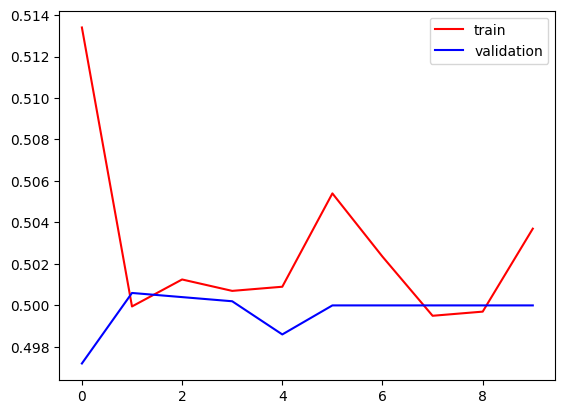

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

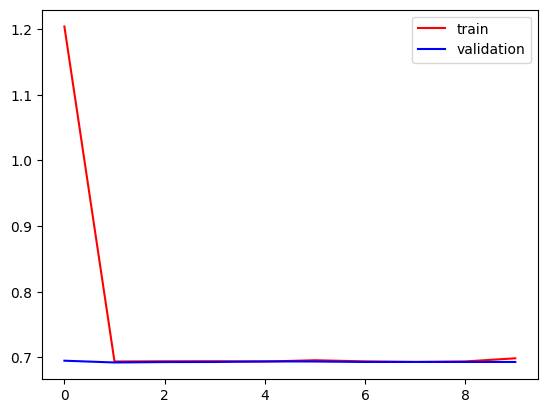

In [26]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [27]:
# Its a good model. So,Saving the model
model1.save('model_iteration_1.h5')

In [28]:
# To load the model back
new_model = keras.models.load_model('model_iteration_1.h5')

In [29]:
new_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │      16,777,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,879,811 (64.39 MB)

 Trainable params: 16,879,361 (64.39 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 2 (12.00 B)

In [30]:
import cv2

In [34]:
test_img = cv2.imread('/content/cats.jpg')

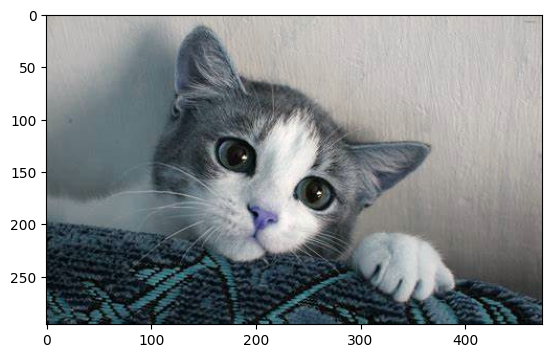

In [35]:
import matplotlib.pyplot as plt
plt.imshow(test_img)

In [36]:
test_img.shape

(296, 474, 3)

In [37]:
test_img = cv2.resize(test_img,(256,256))

In [38]:
test_input = test_img.reshape((1,256,256,3))

In [39]:
test_input.shape

(1, 256, 256, 3)

In [40]:
model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step


array([[1.]], dtype=float32)

## Testing

In [41]:
test_img = cv2.imread('/content/dog.jpg')

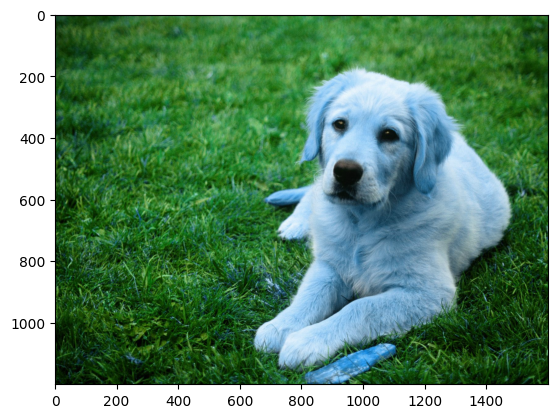

In [42]:
import matplotlib.pyplot as plt
plt.imshow(test_img)

In [43]:
test_img.shape

(1200, 1600, 3)

In [44]:
test_img = cv2.resize(test_img,(256,256))

In [45]:
test_input = test_img.reshape((1,256,256,3))

In [46]:
model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


array([[0.]], dtype=float32)

In [53]:
# now this is happening because of the imablanced distribution of images
# in the batches. For eg number of 0 and 1 in image 1
zero_count=0
one_count=1
for i in x[1].numpy():
  if i==0:
    zero_count+=1
  else:
    one_count+=1
print(zero_count)
print(one_count)
# if we will see some other batch, data distribution would be different.
# so we r going to deal with this using data augmentation technique.
# data augmentation is nothing but adding more data.
# For eg. if u have cat image at the center of the image with feet parallel to x-axis,
# then in data augmentation the images are created by tilting this image on the right left,
# sometimes upside down,  We will not do upside down cat because that is unusual for a cat.
# we can even flip the image,
# So the idea over here is by 1 image , we can create 2-3 more images.

19
14


## Data Augmentation

Single image example

In [59]:
#from tensorflow.keras.layers import preprocessing

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(256,256,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
  ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [61]:
#from keras.preprocessing import image
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [62]:
img = image.load_img('/content/cats.jpg', target_size=(200,200))

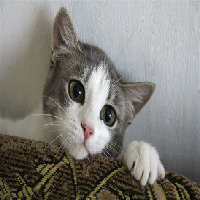

In [63]:
img

In [64]:
datagen = ImageDataGenerator(
     rotation_range=30,
     shear_range=0.2,
     zoom_range=0.2,
     horizontal_flip=True,
)

In [65]:
img = image.img_to_array(img)

In [66]:
img.shape

(200, 200, 3)

In [67]:
input_batch = img.reshape(1,200,200,3)

In [68]:
i = 0
# see it under dogs_vs_cats folder.
for output in datagen.flow(input_batch, batch_size=1, save_to_dir='/content/dogs_vs_cats'):
  i = i + 1

  if i == 5:
    break

Whole directory

In [75]:
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1./255, # 1/255 would perform integer division, resulting in 0; But 1./255 forces floating-point division:
    shear_range=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255) # normalizing the data range from [0,1]

train_generator = train_datagen.flow_from_directory(
    '/content/train',
    target_size = (150,150),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    '/content/test',
    target_size = (150,150),
    batch_size=batch_size,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [70]:
# create CNN model

model = Sequential()

model.add(data_augmentation)

model.add(Conv2D(32,kernel_size=(3,3),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))


model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [71]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,454,017 (32.25 MB)

 Trainable params: 8,453,697 (32.25 MB)

 Non-trainable params: 320 (1.25 KB)

In [72]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 98s 143ms/step - accuracy: 0.5392 - loss: 1.4238 - val_accuracy: 0.5440 - val_loss: 0.9850
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 140s 145ms/step - accuracy: 0.6002 - loss: 0.6537 - val_accuracy: 0.6252 - val_loss: 0.6540
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 93s 149ms/step - accuracy: 0.6408 - loss: 0.6368 - val_accuracy: 0.7176 - val_loss: 0.5718
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 141s 148ms/step - accuracy: 0.6915 - loss: 0.5924 - val_accuracy: 0.7008 - val_loss: 0.5724
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 145s 153ms/step - accuracy: 0.7134 - loss: 0.5717 - val_accuracy: 0.7136 - val_loss: 0.5590
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 137s 145ms/step - accuracy: 0.7137 - loss: 0.5634 - val_accuracy: 0.7328 - val_loss: 0.5434
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 145ms/step - accuracy: 0.7158 - loss: 0.5672 - val_accuracy: 0.7328 - val_loss: 0.5649
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 92s 148ms/step - accuracy: 0.7393 - lo

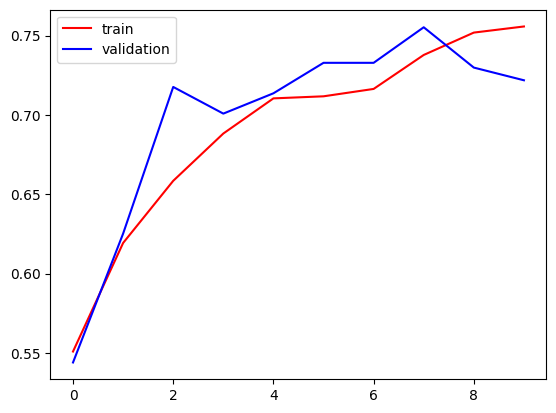

In [73]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

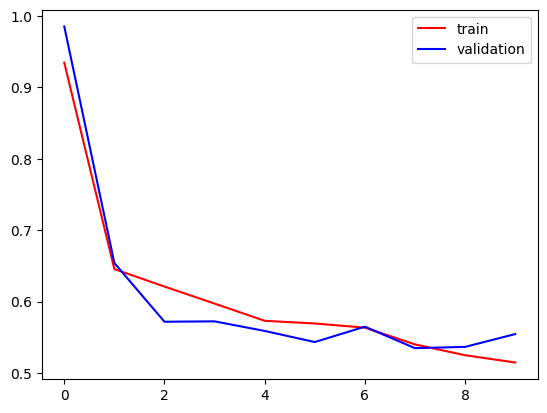

In [74]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [76]:
# u can directly search horse vs human dataset from kaggle and download zip file
# or directly get data through api with the help of url everything after dataset in url.
!kaggle datasets download -d sanikamal/horses-or-humans-dataset

Dataset URL: https://www.kaggle.com/datasets/sanikamal/horses-or-humans-dataset
License(s): other
 99% 304M/307M [00:15<00:00, 21.6MB/s]
100% 307M/307M [00:16<00:00, 20.1MB/s]


In [77]:
# extracting zip file
import zipfile
zip_ref = zipfile.ZipFile('/content/horses-or-humans-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()
# after extracting we see 3 folders. horse-or-human, train and validation.
# u will need train and validation. horse-or-human contains duplicate data only.

In [78]:
#Training data and validation data from directory
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/horse-or-human/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=8,
    image_size=(256,256),
    seed=12
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/horse-or-human/validation',
    labels='inferred',
    label_mode = 'int',
    batch_size=8,
    image_size=(256,256),
    seed=12
)

Found 1027 files belonging to 2 classes.
Found 256 files belonging to 2 classes.


In [79]:
len(train_ds)

129

In [80]:
for i in train_ds:
  x = i
  break

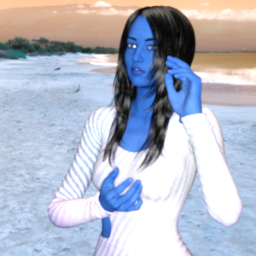

In [81]:
from google.colab.patches import cv2_imshow
cv2_imshow(x[0][-1].numpy())

In [82]:
x[1]

<tf.Tensor: shape=(8,), dtype=int32, numpy=array([0, 0, 0, 0, 1, 0, 0, 1], dtype=int32)>

In [ ]:
# so how u will improve the performance of ur model is totally up to u.